# Which version of the website should you use?

## 📖 Background
You work for an early-stage startup in Germany. Your team has been working on a redesign of the landing page. The team believes a new design will increase the number of people who click through and join your site. 

They have been testing the changes for a few weeks and now they want to measure the impact of the change and need you to determine if the increase can be due to random chance or if it is statistically significant.

## 💾 The data
The team assembled the following file:

#### Redesign test data
- "treatment" - "yes" if the user saw the new version of the landing page, no otherwise.
- "new_images" - "yes" if the page used a new set of images, no otherwise.
- "converted" - 1 if the user joined the site, 0 otherwise.

The control group is those users with "no" in both columns: the old version with the old set of images.

In [1]:
import pandas as pd
df = pd.read_csv('./data/redesign.csv')
df.head()

,treatment,new_images,converted
0,yes,yes,0
1,yes,yes,0
2,yes,yes,0
3,yes,no,0
4,no,yes,0


## 💪 Challenge
Complete the following tasks:

1. Analyze the conversion rates for each of the four groups: the new/old design of the landing page and the new/old pictures.
2. Can the increases observed be explained by randomness? (Hint: Think A/B test)
3. Which version of the website should they use?

## 🧑‍⚖️ Judging criteria

We will randomly select ten winners from the correct submissions for this challenge.

The winners will receive DataCamp merchandise.

## ✅ Checklist before publishing
- Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
- Remove redundant cells like the judging criteria, so the workbook is focused on your answers.
- Check that all the cells run without error.

## ⌛️ Time is ticking. Good luck!

# Experiment design

We formulate the hypothesis. That way our interpretation of the results is correct as well as rigorous.
Given we don’t know if the new design will perform better, worse or the same as our current design, we’ll choose a two-tailed test:

Hypothesis:
- Ho: p = po
- Ha: p != po
    
where p and pₒ stand for the conversion rate of the new and old design, respectively. We’ll also set a confidence level of 95%:
- α = 0.05   

If the p-value is lower than α, then we reject the Null hypothesis. Since our α=0.05 (indicating 5% probability), our confidence (1 — α) is 95%. We want to be 95% confident it is statistically different from the conversion rate of our old design, before we decide to reject the Null hypothesis Hₒ.


# Libraries

In [2]:
import pandas as pd
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import numpy as np
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Exploratoy Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40484 entries, 0 to 40483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   treatment   40484 non-null  object
 1   new_images  40484 non-null  object
 2   converted   40484 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 949.0+ KB


In [4]:
# Type of the feature
df.dtypes.value_counts()

object    2
int64     1
dtype: int64

## Missing values

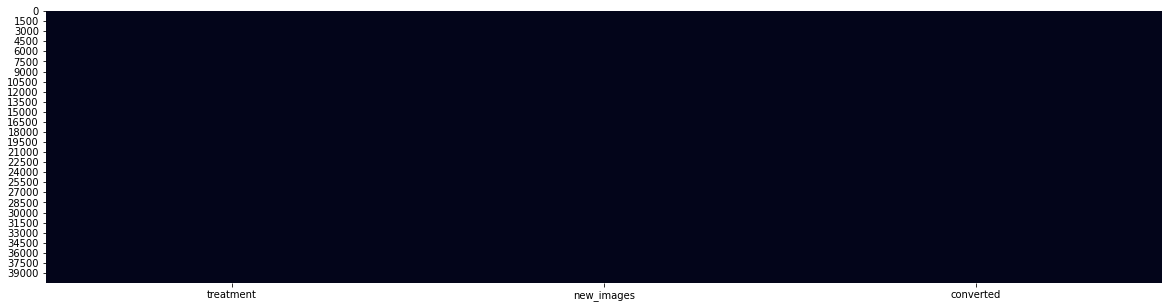

In [5]:
plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [6]:
# Number of missing values by feaure
df.isna().sum()

treatment     0
new_images    0
converted     0
dtype: int64

**Insights:**

- There are not missing values

## Duplicate values

**Insights:**
- We assume there are not duplicated values in the dataframe, because there is not a feature where we can check this as an ID.

# Groups

In [7]:
pd.crosstab(df['treatment'], df['new_images'])

new_images,no,yes
treatment,,
no,10121,10121
yes,10121,10121


**Insights:**
- we can see that there are four different groups in our data set.

## Separation into groups

In [8]:
def groups(x):
    
    x, y = x
    if (x == 'no') & (y == 'no'):
        return 'control'
    elif (x == 'no') & (y == 'yes'):
        return 'old design with new images'
    elif (x == 'yes') & (y == 'yes'):
        return 'new desing'
    else:
        return 'new desing with new images'

In [9]:
df['groups'] = df[['treatment','new_images']].apply(groups, axis=1)
df.head()

,treatment,new_images,converted,groups
0,yes,yes,0,new desing
1,yes,yes,0,new desing
2,yes,yes,0,new desing
3,yes,no,0,new desing with new images
4,no,yes,0,old design with new images


## % Converted by groups

In [10]:
df_info = pd.DataFrame()
df_info['Total user'] =  df.groupby('groups').apply(lambda x: x.shape[0])
df_info['Users converted'] = df.groupby('groups').apply(lambda x: x['converted'].sum())
df_info['% Converted'] = df.groupby('groups').apply(lambda x: round((x['converted'].sum()/ x['converted'].shape[0])*100,2))
df_info

,Total user,Users converted,% Converted
groups,,,
control,10121,1084,10.71
new desing,10121,1151,11.37
new desing with new images,10121,1215,12.00
old design with new images,10121,1139,11.25


**Insights:**
- we can observe that the other 3 groups that are not control groups there is an increase of converted users, we have to check if this increase is statistically significant and which was the one with the highest conversion. 


# Sample size

The sample size that we need is estimated through Power analysis, and it depends on:
- Power of the test (1 — β): This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 by convention (here’s more info on statistical power, if you are curious)
- Alpha value (α): The critical value we set earlier to 0.05
- Effect size: How big of a difference we expect there to be between the conversion rates

As we can see above the conversion rate of our control group is approximately 10% and we want at least a 2% increase in conversion with the new and other designs reaching a 12% conversion rate.

In [11]:
baseline_rate = df[(df['treatment'] == 'no') & (df['new_images'] == 'no')]['converted'].sum()/ df[(df['treatment'] == 'no') & (df['new_images'] == 'no')].shape[0]
print("Conversion rate of our control group - Baseline {}".format(baseline_rate))

Conversion rate of our control group - Baseline 0.10710404110265784


In [12]:
significant_rate = 0.02

effect_size = sms.proportion_effectsize(baseline_rate, baseline_rate + significant_rate)
required_sample = sms.NormalIndPower().solve_power(effect_size,
                                                  power=0.8,
                                                  alpha=0.05,
                                                  ratio=1)

required_sample = ceil(required_sample)
print("Required sample size for the test by group: {}".format(round(required_sample)))

Required sample size for the test by group: 4051


# Select Groups

## Control Group

In [13]:
control_group = df[(df['treatment'] == 'no') & (df['new_images'] == 'no')].sample(n=required_sample, random_state=27)
control_group.head()

,treatment,new_images,converted,groups
11397,no,no,0,control
9099,no,no,0,control
4707,no,no,0,control
5108,no,no,0,control
1481,no,no,0,control


## Control Group with new images

In [14]:
control_newimages = df[(df['treatment'] == 'no') & (df['new_images'] == 'yes')].sample(n=required_sample, random_state=27)
control_newimages.head()

,treatment,new_images,converted,groups
11279,no,yes,1,old design with new images
9202,no,yes,0,old design with new images
4820,no,yes,0,old design with new images
5160,no,yes,0,old design with new images
1654,no,yes,0,old design with new images


## Treatment Group

In [15]:
treatment_group = df[(df['treatment'] == 'yes') & (df['new_images'] == 'no')].sample(n=required_sample, random_state=27)
treatment_group.head()

,treatment,new_images,converted,groups
11437,yes,no,1,new desing with new images
9329,yes,no,0,new desing with new images
4751,yes,no,0,new desing with new images
5183,yes,no,0,new desing with new images
1663,yes,no,0,new desing with new images


## Treatment Group with new images

In [16]:
treatment_newimages = df[(df['treatment'] == 'yes') & (df['new_images'] == 'yes')].sample(n=required_sample, random_state=27)
treatment_newimages.head()

,treatment,new_images,converted,groups
11310,yes,yes,0,new desing
9204,yes,yes,0,new desing
4864,yes,yes,0,new desing
5331,yes,yes,0,new desing
1643,yes,yes,1,new desing


# Dataframe with sample groups

In [17]:
ab_test = pd.concat([control_group, control_newimages, treatment_group, treatment_newimages]).reset_index(drop=True)
ab_test

,treatment,new_images,converted,groups
0,no,no,0,control
1,no,no,0,control
2,no,no,0,control
3,no,no,0,control
4,no,no,0,control
...,...,...,...,...
16199,yes,yes,0,new desing
16200,yes,yes,0,new desing
16201,yes,yes,0,new desing
16202,yes,yes,1,new desing


## % Converted by groups with the selected sample

In [18]:
conversion_rates = ab_test.groupby('groups')['converted'].agg([np.mean,
                                                              np.std,
                                                              stats.sem])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
groups,,,
control,0.108,0.310,0.005
new desing,0.103,0.304,0.005
new desing with new images,0.122,0.327,0.005
old design with new images,0.111,0.314,0.005


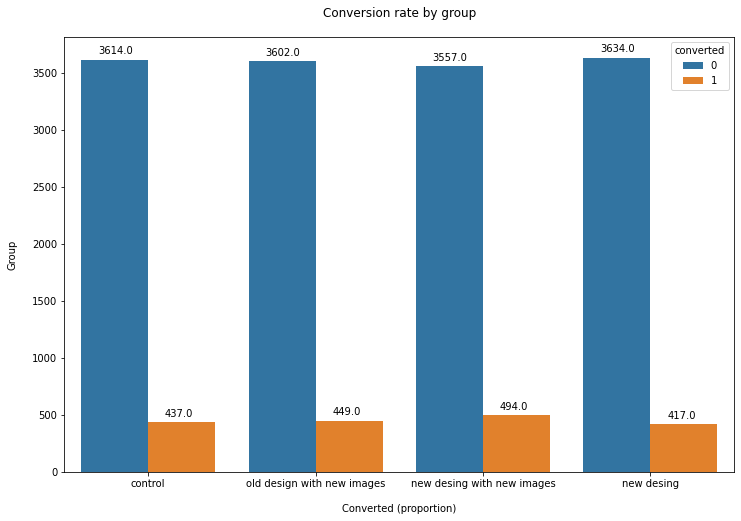

In [19]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x="groups", hue="converted", data=ab_test)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Converted (proportion)', labelpad=15)
plt.ylabel('Group', labelpad=15)

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

# A/B testing with Sample Data

## A/B testing with respect to the control group and the treatment group

In [20]:
control_results = control_group['converted']
treat_results = treatment_group['converted']

# Number of samples by group
control_samples = control_results.count()
treat_samples = treat_results.count()
nobs = [control_samples, treat_samples]

# Users converted
successes = [control_results.sum(), treat_results.sum()]

In [21]:
z_stat, p_value = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

In [22]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {p_value:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -1.99
p-value: 0.047
ci 95% for control group: [0.098, 0.117]
ci 95% for treatment group: [0.112, 0.132]


Since our p-value=0.047 is below our α=0.05 threshold, we can reject the Null hypothesis Hₒ, which means that our new design perform significantly different than our control group.

if we look at the confidence interval for the treatment group [0.1112, 0.132] we notice that:
- It includes our target value of 12.7% (the 2% uplift we were aiming for)

## A/B Testing with respect control group and control with new images group

In [23]:
control_results = control_group['converted']
control_newimages_results = control_newimages['converted']

# Number of samples by group
control_samples = control_results.count()
control_newimages_samples = control_newimages_results.count()
nobs = [control_samples, control_newimages_samples]

# Users converted
successes = [control_results.sum(), control_newimages_results.sum()]

In [24]:
z_stat, p_value = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

In [25]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {p_value:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for control group with new images: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.43
p-value: 0.669
ci 95% for control group: [0.098, 0.117]
ci 95% for control group with new images: [0.101, 0.121]


Since our p-value=0.669 is above our α=0.05 threshold, we can't reject the Null hypothesis Hₒ, which means that our control design with new images dit not perform significantly different than our control group.

if we look at the confidence interval for the control group with new images [0.101, 0.121] we notice that:
- It includes our baseline value of 10.7% conversion rate
- It doesn't include our target value of 12.7% (the 2% uplift we were aiming for)

## A/B Testing with respect control group and treatment with new images group

In [26]:
control_results = control_group['converted']
treatment_newimages_results = treatment_newimages['converted']

# Number of samples by group
control_samples = control_results.count()
treatment_newimages_samples = treatment_newimages_results.count()
nobs = [control_samples, treatment_newimages_samples]

# Users converted
successes = [control_results.sum(), treatment_newimages_results.sum()]

In [27]:
z_stat, p_value = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

In [28]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {p_value:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group with new images: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.72
p-value: 0.469
ci 95% for control group: [0.098, 0.117]
ci 95% for treatment group with new images: [0.094, 0.112]


Since our p-value=0.469 is above our α=0.05 threshold, we can't reject the Null hypothesis Hₒ, which means that our control design with new images dit not perform significantly different than our control group.

if we look at the confidence interval for the control group with new images [0.094, 0.112] we notice that:
- It includes our baseline value of 10.7% conversion rate
- It doesn't include our target value of 12.7% (the 2% uplift we were aiming for)

# Using All data

## A/B Testing with respect control group and treatment group

In [29]:
control_results = df[(df['treatment'] == 'no') & (df['new_images'] == 'no')]['converted']
treat_results = df[(df['treatment'] == 'yes') & (df['new_images'] == 'no')]['converted']

# Number of samples by group
control_samples = control_results.count()
treat_samples = treat_results.count()
nobs = [control_samples, treat_samples]

# Users converted
successes = [control_results.sum(), treat_results.sum()]

In [30]:
z_stat, p_value = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

In [31]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {p_value:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -2.90
p-value: 0.004
ci 95% for control group: [0.101, 0.113]
ci 95% for treatment group: [0.114, 0.126]


Since our p-value=0.004 is below our α=0.05 threshold, we can reject the Null hypothesis Hₒ, which means that our new design perform significantly different than our control group.

Additionally, if we look at the confidence interval for the treatment group [0.114, 0.126] we notice that:
- It includes our target value of 12.7% (the 2% uplift we were aiming for)

## A/B Testing with respect control group and control with new images group

In [32]:
control_results = df[(df['treatment'] == 'no') & (df['new_images'] == 'no')]['converted']
control_newimages_results = df[(df['treatment'] == 'no') & (df['new_images'] == 'yes')]['converted']

# Number of samples by group
control_samples = control_results.count()
control_newimages_samples = control_newimages_results.count()
nobs = [control_samples, control_newimages_samples]

# Users converted
successes = [control_results.sum(), control_newimages_results.sum()]

In [33]:
z_stat, p_value = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

In [34]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {p_value:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for control group with new images: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -1.24
p-value: 0.216
ci 95% for control group: [0.101, 0.113]
ci 95% for control group with new images: [0.106, 0.119]


Since our p-value=0.216 is above our α=0.05 threshold, we can't reject the Null hypothesis Hₒ, which means that our control design with new images dit not perform significantly different than our control group.

if we look at the confidence interval for the control group with new images [0.106, 0.119] we notice that:
- It includes our baseline value of aprox. 10.7% conversion rate
- It doesn't include our target value of 12.7% (the 2% uplift we were aiming for)

## A/B Testing with respect control group and treatment with new images group

In [35]:
control_results = df[(df['treatment'] == 'no') & (df['new_images'] == 'no')]['converted']
treatment_newimages_results = df[(df['treatment'] == 'yes') & (df['new_images'] == 'yes')]['converted']

# Number of samples by group
control_samples = control_results.count()
treatment_newimages_samples = treatment_newimages_results.count()
nobs = [control_samples, treatment_newimages_samples]

# Users converted
successes = [control_results.sum(), treatment_newimages_results.sum()]

In [36]:
z_stat, p_value = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

In [37]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {p_value:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -1.50
p-value: 0.133
ci 95% for control group: [0.101, 0.113]
ci 95% for treatment group: [0.108, 0.120]


Since our p-value=0.133 is above our α=0.05 threshold, we can't reject the Null hypothesis Hₒ, which means that our control design with new images dit not perform significantly different than our control group.

if we look at the confidence interval for the control group with new images [0.108, 0.120] we notice that:
- It includes our baseline value of aprox. 10.7% conversion rate
- It doesn't include our target value of 12.7% (the 2% uplift we were aiming for)

# Conclusion

- As can be seen in the results, the only group that performed significantly different and better from the control group was the group with the new design and no new images. So, we should use this version.
- It can be seen that the appropriate sample of groups was chosen since the same conclusion was reached by using all the data.